In [23]:
import os
import sys
import glob
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [24]:
#from numpy.random import seed
#seed(1)
#tf.random.set_seed(1)

### Dataset and Preprocessing

In [25]:
array_tau = np.load('ntuples/dataset_tau.npy')
array_qcd = np.load('ntuples/dataset_fake_tau.npy')
array_tau_Glob = np.load('ntuples/datGlob_tau.npy')
array_qcd_Glob = np.load('ntuples/datGlob_fake_tau.npy')
print(array_tau.shape)
print(array_qcd.shape)
print(array_tau_Glob.shape)
print(array_qcd_Glob.shape)

(4916408, 10, 8)
(1060682, 10, 8)
(4916408, 9)
(1060682, 9)


In [26]:
big_array = np.append(array_tau,array_qcd, axis=0)
print(big_array.shape)
tot_max = np.max( np.max(big_array,axis=1), axis=0)
tot_min = np.min( np.min(big_array,axis=1), axis=0)
big_array_scaled = (big_array - tot_min)/(tot_max - tot_min)

array_tau_scaled = (array_tau - tot_min)/(tot_max - tot_min)
array_qcd_scaled = (array_qcd - tot_min)/(tot_max - tot_min)
#print(array_tau_scaled[len(array_tau_scaled)-1,:])
#print(big_array_scaled[len(array_tau_scaled)-1,:])

comparison = array_tau_scaled == big_array_scaled[:len(array_tau_scaled),:]
equal_arrays = comparison.all()
print(equal_arrays)

(5977090, 10, 8)
True


Building of test and train

In [27]:
train = {}
test = {}

test_percentage = 18#%
test_len = math.floor(len(array_tau)*test_percentage/100)
coordinates = []
[coordinates.append([True, True, False, False, False, False, False, False]) for i in range( 10 ) ]
coordinates = np.reshape(np.array(coordinates), ( 10, 8) )

np.random.shuffle(array_tau)
np.random.shuffle(array_qcd)

test_len = 100000
test['features'] = array_tau_scaled[:test_len]
test['features'] = np.append(test['features'], array_qcd_scaled[:test_len], axis = 0)
test['points'] = np.reshape( test['features'][:,coordinates], ( len(test['features']), 10, 2) )
test['label'] = np.ones(test_len)
test['label'] = np.append(test['label'],np.zeros(test_len), axis = 0)

train_len = 300000
train['features'] = array_tau_scaled[test_len:train_len+test_len]
train['features'] = np.append(train['features'], array_qcd_scaled[test_len:train_len+test_len], axis = 0)
train['points'] = np.reshape( train['features'][:,coordinates], ( len(train['features']), 10, 2) )
train['label'] = np.ones( train_len )
train['label'] = np.append(train['label'], np.zeros(train_len), axis = 0)
print(train['label'][199999])

1.0


In [28]:
print(train['points'].shape)
print(test['points'].shape)
print(train['features'].shape)
print(test['features'].shape)
print(train['label'].shape)
print(test['label'].shape)

(600000, 10, 2)
(200000, 10, 2)
(600000, 10, 8)
(200000, 10, 8)
(600000,)
(200000,)


In [29]:
def shuffle(dict_data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    shuffle_indices = np.arange( len(dict_data['points']))#Len data.points has to be the same for data.features and data.label
    np.random.shuffle(shuffle_indices)
    for k in dict_data:
        dict_data[k] = dict_data[k][shuffle_indices]
    return shuffle_indices, dict_data

## Model

In [30]:
#Location Representation(frequencies)
def _cal_freq_list(setting):
    if setting.freq_init == "random":
        # the frequence we use for each block, alpha in ICLR paper
        # freq_list shape: (frequency_num)
        freq_list = np.random.random(size=[setting.frequency_num]) * setting.max_radius
    elif setting.freq_init == "geometric":

        log_timescale_increment = (math.log(float(setting.max_radius) / float(setting.min_radius)) /
          (setting.frequency_num*1.0 - 1))

        timescales = setting.min_radius * np.exp(
            np.arange(setting.frequency_num).astype(float) * log_timescale_increment)
        freq_list = 1.0/timescales
    return freq_list

def cal_freq_list(setting):
    freq_list = _cal_freq_list(setting)
    return freq_list

def cal_freq_mat(setting):
    # freq_mat shape: (frequency_num, 1)
    freq_mat = np.expand_dims(setting.freq_list, axis = 1)
    # self.freq_mat shape: (frequency_num, 3)
    freq_mat = np.repeat(freq_mat, 3, axis = 1)
    return freq_mat

#Location Representation
def make_input_embeds(setting, K, coords):
    if type(coords) == np.ndarray:
        assert setting.coord_dim == np.shape(coords)[2]
        coords = list(coords)
    elif type(coords) == list:
        assert setting.coord_dim == len(coords[0][0])
    #else:
        #raise Exception("Unknown coords data type for GridCellSpatialRelationEncoder")
    
    # (batch_size, num_context_pt, coord_dim)
    #coords_mat = np.asarray(coords).astype(float)
    batch_size = tf.shape(coords)[0]
    num_nodes = setting.num_points
    num_context_nod = K#seems to be our k

    # compute the dot product between [deltaX, deltaY] and each unit_vec 
    # (batch_size, num_nodes, num_context_nod, 1)
    angle_mat1 = tf.expand_dims(tf.einsum('ijkl,l->ijk',coords, setting.unit_vec1), axis = -1)
    # (batch_size, num_nodes, num_context_nod, 1)
    angle_mat2 = tf.expand_dims(tf.einsum('ijkl,l->ijk',coords, setting.unit_vec2), axis = -1)
    # (batch_size, num_nodes, num_context_nod, 1)
    angle_mat3 = tf.expand_dims(tf.einsum('ijkl,l->ijk',coords, setting.unit_vec3), axis = -1)

    # (batch_size, num_nodes, num_context_nod, 3)
    angle_mat = tf.concat([angle_mat1, angle_mat2, angle_mat3], axis = -1)
    # (batch_size, num_nodes, num_context_nod, 1, 3)
    angle_mat = tf.expand_dims(angle_mat, axis = -2)
    ## (batch_size, num_nodes, num_context_nod, frequency_num, 3) #Da qui servono le frequense, che sono su self
    angle_mat = tf.repeat(angle_mat, setting.frequency_num, axis = -2)
    ## (batch_size, num_nodes, num_context_nod, frequency_num, 3)
    angle_mat = angle_mat * setting.freq_mat
    ## (batch_size, num_nodes, num_context_nod, frequency_num*3)
    angle_mat = tf.reshape(angle_mat, (batch_size, num_nodes, num_context_nod, setting.frequency_num*3))
    # make sinuniod function
    # sin for 2i, cos for 2i+1
    # spr_embeds: (batch_size, num_nodes, num_context_pt, frequency_num*6=input_embed_dim)
    spr_embeds_sin = tf.sin(angle_mat)  # dim 2i
    spr_embeds_cos = tf.cos(angle_mat)  # dim 2i+1
    spr_embeds = tf.concat([spr_embeds_cos,spr_embeds_sin], axis=-1)
    return spr_embeds


def First_EdgeConv_layer_DeltaPE (pts, fts, setting, K, channels, with_bn=True, activation='relu', pooling='max', name='edgeconv'):
    D = batch_distance_matrix_general(pts, pts)  # (N, P, P)
    _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)  Becouse top_k returns the largest, using -D we get the smallest values
    indices = indices[:, :, 1:]  # (N, P, K); the 1: allow to esclude distance between each point to itself
    knn_pts = knn(setting.num_points, K, indices, pts)  # (N, P, K, C) So we now use only coords of each point
    knn_pts_center = tf.tile(tf.expand_dims(pts, axis=2), (1, 1, K, 1))  # (N, P, K, C); copia le C K  volte
    spr_embeds_center = make_input_embeds(setting, K, knn_pts_center)
    spr_embeds_neighb = make_input_embeds(setting, K, knn_pts)
    spr_embeds_deltapts = spr_embeds_neighb - spr_embeds_center
    spr_LocRep = tf.concat([spr_embeds_deltapts, knn_pts_center], axis=-1)
    #knn_deltapts = tf.abs(knn_pts_center - knn_pts)
    #spr_embeds = make_input_embeds(setting, K, knn_deltapts)
    #knn_LocRep = tf.concat([knn_pts_center, spr_embeds], axis=-1)  # (N, P, K, C + 6*freq_num); abbiamo 2*C perche anniamo le C del centro e le C del vicino selezionato
    print("spr_LocRep shape =", tf.shape(spr_LocRep),"\n")
    x = spr_LocRep #knn_LocRep
    for idx, channel in enumerate(channels):
        x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
        if with_bn:
            x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
        if activation:
            x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)
            
    if pooling == 'max':
        fts = tf.reduce_max(x, axis=2)  # (N, P, C')
    else:
        fts = tf.reduce_mean(x, axis=2)  # (N, P, C')
    return fts

def get_neighborhood_representation(setting, K, distances):
    '''
    Gets the Position Embedding of the pointpairs in the dataset based on relative distance
    '''
    setting.a = tf.constant([[1, 0], [-0.5, -math.sqrt(3) / 2], [-0.5, math.sqrt(3) / 2]])
    scales = tf.constant([setting.min_radius * (setting.max_radius / setting.min_radius) ** (s / (setting.frequency_num - 1)) for s in range(setting.frequency_num)])
    scaled_proj = tf.einsum('bnkr, s -> bnkrs', tf.einsum('ijkl,sl->ijks', distances, setting.a), 1 / scales)
    batch_size = tf.shape(scaled_proj)[0]
    neighborhood_representation = tf.concat((tf.cos(scaled_proj), tf.sin(scaled_proj)), axis=-1)
    neighborhood_representation = tf.reshape( neighborhood_representation, (batch_size, setting.num_points, K, setting.frequency_num*6) )
    return neighborhood_representation


def First_EdgeConv_layer (pts, setting, K, channels, with_bn=True, activation='relu', pooling='max', name='edgeconv'):
    D = batch_distance_matrix_general(pts, pts)  # (N, P, P)
    _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)  Becouse top_k returns the largest, using -D we get the smallest values
    indices = indices[:, :, 1:]  # (N, P, K); the 1: allow to esclude distance between each point to itself
    knn_pts = knn(setting.num_points, K, indices, pts)  # (N, P, K, C) So we now use only coords of each point
    knn_pts_center = tf.tile(tf.expand_dims(pts, axis=2), (1, 1, K, 1))  # (N, P, K, C); copia le C K  volte
    knn_deltapts = tf.abs(knn_pts_center - knn_pts)
    #spr_embeds = make_input_embeds(setting, K, knn_deltapts)
    spr_embeds = get_neighborhood_representation(setting, K, knn_deltapts)
    knn_LocRep = tf.concat([knn_pts_center, spr_embeds], axis=-1)  # (N, P, K, C + 6*freq_num); abbiamo 2*C perche anniamo le C del centro e le C del vicino selezionato
    print("knn_LocRep shape =", tf.shape(knn_LocRep),"\n")
    x = knn_LocRep
    for idx, channel in enumerate(channels):
        x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
        if with_bn:
            x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
        if activation:
            x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)
            
    if pooling == 'max':
        fts = tf.reduce_max(x, axis=2)  # (N, P, C')
    else:
        fts = tf.reduce_mean(x, axis=2)  # (N, P, C')
    return fts

#DGCNN

# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):#It gives a name_scope at submitted operators, so 'r_A', when executed, will have name 'dmat/r_A'
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))#'Distance' between A and B
        return tf.math.sqrt(D)
    
def knn(num_points, k, topk_indices, features): #k-nearest-neighbours
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1)) #(N, P, K, 1)
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2) indices ha, per ogni elemento, due numeri: il primo scala rispetto al batch
        return tf.gather_nd(features, indices)
    
def edge_conv(points, features, num_points, K, channels, with_bn=True, activation='relu', pooling='max', name='edgeconv'):
    """EdgeConv
    Args:
        num_points: number of points per event (1024)
        K: int, number of neighbors
        in_channels: # of input channels
        channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)  Becouse top_k returns the largest, using -D we get the smallest values
        indices = indices[:, :, 1:]  # (N, P, K); the 1: allow to esclude distance between each point to itself

        fts = features # (N, P, C)
        knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C); copia le C K  volte
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C); abbiamo 2*C perche anniamo le C del centro e le C del vicino selezionato
        ### nel passaggio sopra lui accoppia le fts del nodo di riferimento e LA DIFFERENZA del k-vicino con questo...
        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts


def _DGCNN_base(points, features=None, mask=None, setting=None, fts_dict=None, name='DGCNN_SG'): #it is used by get_DGCNN to build the net
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optional

    with tf.name_scope(name):
        if features is None:
            features = points
        
        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # 1 if valid
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 99   
            
        fts = tf.squeeze( keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)) , axis=2)
        #fts shape = features shape
        if mask is not None:###Ho spostato la maschera qui
            fts = tf.multiply(fts, mask)

        for layer_idx, layer_param in enumerate(setting.conv_params):# Here creates the 4 edge_conv layers
            K, channels = layer_param
            if layer_idx == 0:
                pts = points
                pts = First_EdgeConv_layer(pts, setting, K, channels, with_bn=True, activation='relu',
                                    pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))
                fts = tf.gather(features, [2,3,4,5,6,7], axis = 2)
                fts = tf.concat( [pts, fts] , axis = -1)## concatenare coord embedded with features
            else :
                #pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts) #nell'originale prende points solo la prima volta, ma li pts e fts coincidono quindi è uguale...
                pts = fts
                print("fts in edge_conv =",tf.shape(fts))
                fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))
            string = 'fts_%d' % (layer_idx)
            fts_dict[string]=fts
            
        fts = tf.concat([fts_dict['fts_0'], fts_dict['fts_1'], fts_dict['fts_2'], fts_dict['fts_3']], axis=-1)
        fts = keras.layers.Dense(32, activation='relu')(fts)#(N,P,32=C) ##HERE IS DIFFERENCEEE 32 instead of setting.num_points
        pool_avg = tf.reduce_mean(fts, axis=1, name='pool_mean')  # (N, C)
        pool_max = tf.reduce_max(fts, axis=1, name='pool_max')  # (N, C)  ### HERE
        pool = tf.concat([pool_avg,pool_max], axis=-1, name='pool_concat') #(N,2*C)
        #pool = tf.reduce_mean(fts, axis=1)  # (N, C)
        
            
        if setting.fc_params is not None:#Here it creates the FC layers
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='sigmoid')(x) ###Sigmoid for 1-dim output, not softmax
            return out  # (N, num_classes)
        else:
            return pool


class _DotDict:
    pass

def get_DGCNN(num_classes, input_shapes):#Here we set all parameters of the net, its structure and then the _DGCNN_base really create it
    """
    Parameters
    ----------
    num_classes : int
        Number of output classes. Are classes that beongs to dataset, the ones we want train (e.g. ariplain, car,etc.)
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    fts_dict = {}
    setting = _DotDict()
    setting.num_class = num_classes
    #setting of Location Representation
    setting.freq_init = "geometric"
    setting.frequency_num = 3 #5
    setting.max_radius = 100
    setting.min_radius = 1
    setting.unit_vec1 = tf.constant([1.0, 0.0],dtype = float)                    # 0  we need tf_constant to use them with tf_tensor
    setting.unit_vec2 = tf.constant([-1.0/2.0, math.sqrt(3)/2.0])  # 120 degree
    setting.unit_vec3 = tf.constant([-1.0/2.0, -math.sqrt(3)/2.0]) # 240 degree
    setting.freq_list = cal_freq_list(setting)
    setting.freq_mat = cal_freq_mat(setting)

    # conv_params: list of tuple in the format (K, (C1, C2, C3)); where c1, c2, c3 are MLP layers inside each edge conv, respectiveli...so at each edge coonv layer we can use dfferent numbers and lists
    setting.conv_params = [
        (3, (8, 8, 8)),  #First_EdgeConv_Layer
        (3, (8, 8, 8)),
        (3, (16, 16, 16)),
        (3, (32, 32, 32)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [
        (64, 0.5),
        (32, 0.5),
        ]
    setting.num_points = input_shapes['points'][0]# = 10

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _DGCNN_base(points, features, mask, setting, fts_dict, name='DGCNN_SG')
    
    return keras.Model(inputs=[points, features], outputs=outputs, name='DGCNN_SG')

In [31]:
num_classes = 1#only tau
input_shapes = {k:train[k].shape[1:] for k in train}
print(input_shapes)
model = get_DGCNN(num_classes, input_shapes)

{'features': (10, 8), 'points': (10, 2), 'label': ()}
knn_LocRep shape = KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 10, 3, 20], name='tf.compat.v1.shape_11/Shape:0', description="created by layer 'tf.compat.v1.shape_11'") 

fts in edge_conv = KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 10, 14], name='tf.compat.v1.shape_12/Shape:0', description="created by layer 'tf.compat.v1.shape_12'")
fts in edge_conv = KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 10, 8], name='tf.compat.v1.shape_14/Shape:0', description="created by layer 'tf.compat.v1.shape_14'")
fts in edge_conv = KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 10, 16], name='tf.compat.v1.shape_16/Shape:0', description="created by layer 'tf.compat.v1.shape_16'")


In [32]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2022-03-17 20:39:26,741] INFO: Learning rate: 0.001000


Model: "DGCNN_SG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose_8 (TFOpL (None, 2, 10)        0           points[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply_12 (TFOpLambda (None, 10, 2)        0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf.linalg.matmul_4 (TFOpLambda) (None, 10, 10)       0           points[0][0]              

                                                                 tf.tile_15[0][0]                 
__________________________________________________________________________________________________
tf.concat_21 (TFOpLambda)       (None, 10, 3, 32)    0           tf.tile_15[0][0]                 
                                                                 tf.math.subtract_15[0][0]        
__________________________________________________________________________________________________
DGCNN_SG_EdgeConv3_conv0 (Conv2 (None, 10, 3, 32)    1024        tf.concat_21[0][0]               
__________________________________________________________________________________________________
DGCNN_SG_EdgeConv3_bn0 (BatchNo (None, 10, 3, 32)    128         DGCNN_SG_EdgeConv3_conv0[0][0]   
__________________________________________________________________________________________________
DGCNN_SG_EdgeConv3_act0 (Activa (None, 10, 3, 32)    0           DGCNN_SG_EdgeConv3_bn0[0][0]     
__________

In [33]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'MC-DGCNN_on_Tau_WITH_LOC_REP_only_tracks.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks = [checkpoint, lr_scheduler]

In [34]:
# Training parameters
batch_size = 1024
epochs = 30

In [ ]:
shuffled_ind, train = shuffle(train)
shuffled_ind, test = shuffle(test)
lim_data = len(train['points'])
history = model.fit( [train['points'][:lim_data],train['features'][:lim_data]],
                    train['label'][:lim_data],
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data= ( [test['points'][:50000],test['features'][:50000]], test['label'][:50000]),
                    #validation_split = 0.15,
                    shuffle=True,
                    callbacks=callbacks)

[2022-03-17 20:39:27,753] INFO: Learning rate: 0.001000


Epoch 1/30
586/586 [==============================] - 29s 46ms/step - loss: 0.5920 - accuracy: 0.6971 - val_loss: 1.4839 - val_accuracy: 0.5003

Epoch 00001: val_accuracy improved from -inf to 0.50026, saving model to model_checkpoints/MC-DGCNN_on_Tau_WITH_LOC_REP_only_tracks.h5


[2022-03-17 20:39:57,102] INFO: Learning rate: 0.001000


Epoch 2/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5579 - accuracy: 0.7290 - val_loss: 0.8052 - val_accuracy: 0.4997


[2022-03-17 20:40:24,769] INFO: Learning rate: 0.001000



Epoch 00002: val_accuracy did not improve from 0.50026
Epoch 3/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5520 - accuracy: 0.7321 - val_loss: 0.7358 - val_accuracy: 0.5347

Epoch 00003: val_accuracy improved from 0.50026 to 0.53472, saving model to model_checkpoints/MC-DGCNN_on_Tau_WITH_LOC_REP_only_tracks.h5


[2022-03-17 20:40:52,731] INFO: Learning rate: 0.001000


Epoch 4/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5488 - accuracy: 0.7337 - val_loss: 0.7894 - val_accuracy: 0.5057


[2022-03-17 20:41:20,304] INFO: Learning rate: 0.001000



Epoch 00004: val_accuracy did not improve from 0.53472
Epoch 5/30
586/586 [==============================] - 28s 48ms/step - loss: 0.5467 - accuracy: 0.7350 - val_loss: 0.7695 - val_accuracy: 0.4997


[2022-03-17 20:41:48,156] INFO: Learning rate: 0.001000



Epoch 00005: val_accuracy did not improve from 0.53472
Epoch 6/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5450 - accuracy: 0.7362 - val_loss: 0.6869 - val_accuracy: 0.5550

Epoch 00006: val_accuracy improved from 0.53472 to 0.55500, saving model to model_checkpoints/MC-DGCNN_on_Tau_WITH_LOC_REP_only_tracks.h5


[2022-03-17 20:42:15,961] INFO: Learning rate: 0.001000


Epoch 7/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5439 - accuracy: 0.7366 - val_loss: 0.7053 - val_accuracy: 0.4541


[2022-03-17 20:42:43,584] INFO: Learning rate: 0.001000



Epoch 00007: val_accuracy did not improve from 0.55500
Epoch 8/30
586/586 [==============================] - 27s 47ms/step - loss: 0.5427 - accuracy: 0.7373 - val_loss: 0.7182 - val_accuracy: 0.5359


[2022-03-17 20:43:10,895] INFO: Learning rate: 0.001000



Epoch 00008: val_accuracy did not improve from 0.55500
Epoch 9/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5420 - accuracy: 0.7375 - val_loss: 0.8062 - val_accuracy: 0.4807


[2022-03-17 20:43:38,491] INFO: Learning rate: 0.001000



Epoch 00009: val_accuracy did not improve from 0.55500
Epoch 10/30
586/586 [==============================] - 27s 47ms/step - loss: 0.5415 - accuracy: 0.7377 - val_loss: 0.7161 - val_accuracy: 0.4366


[2022-03-17 20:44:05,879] INFO: Learning rate: 0.001000



Epoch 00010: val_accuracy did not improve from 0.55500
Epoch 11/30
586/586 [==============================] - 27s 46ms/step - loss: 0.5408 - accuracy: 0.7378 - val_loss: 1.0767 - val_accuracy: 0.4875


[2022-03-17 20:44:33,087] INFO: Learning rate: 0.000100



Epoch 00011: val_accuracy did not improve from 0.55500
Epoch 12/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5382 - accuracy: 0.7396 - val_loss: 0.7221 - val_accuracy: 0.5363


[2022-03-17 20:45:00,892] INFO: Learning rate: 0.000100



Epoch 00012: val_accuracy did not improve from 0.55500
Epoch 13/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5375 - accuracy: 0.7402 - val_loss: 0.7436 - val_accuracy: 0.5224


[2022-03-17 20:45:28,546] INFO: Learning rate: 0.000100



Epoch 00013: val_accuracy did not improve from 0.55500
Epoch 14/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5371 - accuracy: 0.7404 - val_loss: 0.6436 - val_accuracy: 0.6256

Epoch 00014: val_accuracy improved from 0.55500 to 0.62564, saving model to model_checkpoints/MC-DGCNN_on_Tau_WITH_LOC_REP_only_tracks.h5


[2022-03-17 20:45:56,490] INFO: Learning rate: 0.000100


Epoch 15/30
586/586 [==============================] - 28s 47ms/step - loss: 0.5368 - accuracy: 0.7404 - val_loss: 0.5810 - val_accuracy: 0.7065

Epoch 00015: val_accuracy improved from 0.62564 to 0.70654, saving model to model_checkpoints/MC-DGCNN_on_Tau_WITH_LOC_REP_only_tracks.h5


[2022-03-17 20:46:24,362] INFO: Learning rate: 0.000100


Epoch 16/30
120/586 [=====>........................] - ETA: 20s - loss: 0.5376 - accuracy: 0.7395

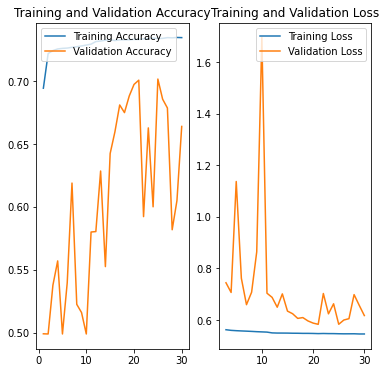

In [18]:
loss=history.history['loss']
val_loss=history.history['val_loss']

mae = history.history['accuracy']
val_mae = history.history['val_accuracy']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[0:], mae[0:], label='Training Accuracy')
plt.plot(epochs_range[0:], val_mae[0:], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range[2:], loss[2:], label='Training Loss')
plt.plot(epochs_range[2:], val_loss[2:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
test_loss, test_acc = model.evaluate( [test['points'],test['features']], test['label'], verbose=2, batch_size = batch_size)

196/196 - 6s - loss: 0.6185 - accuracy: 0.6642


In [21]:
model.load_weights("model_checkpoints/MC-DGCNN_on_Tau_WITH_LOC_REP_only_tracks.h5")#DGCNN_on_Tau.h5

In [22]:
test_loss, test_acc = model.evaluate( [test['points'],test['features']], test['label'], verbose=2, batch_size = batch_size)

196/196 - 6s - loss: 0.5843 - accuracy: 0.7003


In [67]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Beckup of make_input_embeds. It compile but doesn't seem to work really well.
So I could try to work directly on center nodes and on their neigbourhoods, and the we make difference and concat with origial center and go to x...

In [68]:
#Location Representation
def make_input_embeds(setting, K, coords):
    if type(coords) == np.ndarray:
        assert setting.coord_dim == np.shape(coords)[2]
        coords = list(coords)
    elif type(coords) == list:
        assert setting.coord_dim == len(coords[0][0])
    #else:
        #raise Exception("Unknown coords data type for GridCellSpatialRelationEncoder")
    
    # (batch_size, num_context_pt, coord_dim)
    #coords_mat = np.asarray(coords).astype(float)
    batch_size = tf.shape(coords)[0]
    num_nodes = setting.num_points
    num_context_nod = K#seems to be our k

    # compute the dot product between [deltaX, deltaY] and each unit_vec 
    # (batch_size, num_nodes, num_context_nod, 1)
    angle_mat1 = tf.expand_dims(tf.einsum('ijkl,l->ijk',coords, setting.unit_vec1), axis = -1)
    # (batch_size, num_nodes, num_context_nod, 1)
    angle_mat2 = tf.expand_dims(tf.einsum('ijkl,l->ijk',coords, setting.unit_vec2), axis = -1)
    # (batch_size, num_nodes, num_context_nod, 1)
    angle_mat3 = tf.expand_dims(tf.einsum('ijkl,l->ijk',coords, setting.unit_vec3), axis = -1)

    # (batch_size, num_nodes, num_context_nod, 3)
    angle_mat = tf.concat([angle_mat1, angle_mat2, angle_mat3], axis = -1)
    # (batch_size, num_nodes, num_context_nod, 1, 3)
    angle_mat = tf.expand_dims(angle_mat, axis = -2)
    ## (batch_size, num_nodes, num_context_nod, frequency_num, 3) #Da qui servono le frequense, che sono su self
    angle_mat = tf.repeat(angle_mat, setting.frequency_num, axis = -2)
    ## (batch_size, num_nodes, num_context_nod, frequency_num, 3)
    angle_mat = angle_mat * setting.freq_mat
    ## (batch_size, num_nodes, num_context_nod, frequency_num*3)
    angle_mat = tf.reshape(angle_mat, (batch_size, num_nodes, num_context_nod, setting.frequency_num*3))
    # make sinuniod function
    # sin for 2i, cos for 2i+1
    # spr_embeds: (batch_size, num_nodes, num_context_pt, frequency_num*6=input_embed_dim)
    spr_embeds_sin = tf.sin(angle_mat)  # dim 2i
    spr_embeds_cos = tf.cos(angle_mat)  # dim 2i+1
    spr_embeds = tf.concat([spr_embeds_cos,spr_embeds_sin], axis=-1)
    return spr_embeds